In [1]:
# !pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
import torch
import math

from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,attn2map
from ithor_tools.map import single_scenemap
from grad_cam.cam import clip_grad_cam
from FBE.fbe import gridmap
from ai2thor.util.metrics import get_shortest_path_to_object
from ithor_tools.utils import check_vis,step_local_search
# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing
from FBE.step import step_frontier

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_gradcam = clip_grad_cam(device)

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [3]:
gridSize=0.05
scene_name = "FloorPlan_Val1_1"
controller = Controller(
    platform=CloudRendering,
    agentMode="locobot",
    visibilityDistance=1.5,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    width=300,
    height=300,
    fieldOfView=90
)

controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=True,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']

controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[200],
    rotation = dict(x=0,y=270,z=0)
)



INFO - 2022-06-06 22:09:20,219 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


<ai2thor.server.Event at 0x7f2edb60fb50
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [4]:
objects = controller.last_event.metadata['objects']
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


,objectType,objectId,name,position[x],position[y],position[z],rotation[x],rotation[y],rotation[z],distance,...,openness,pickupable,isPickedUp,moveable,mass,salientMaterials,assetId,parentReceptacles,controlledObjects,isMoving
0,Book,Book|+04.01|+00.36|-01.31,Book_12,4.0000,0.3553,-1.3129,359.9892,179.0525,0.0536,1.7200,...,0.0,True,False,False,0.500,[Paper],Book_12,"[CoffeeTable|+03.50|+00.00|-01.31, Floor|+00.0...",None,False
1,Book,Book|+05.62|+00.74|-04.53,Book_14,5.6212,0.7384,-4.5274,359.8715,1.6559,2.1937,3.8478,...,0.0,True,False,False,0.500,[Paper],Book_14,[Desk|+05.57|00.00|-04.57],None,False
2,Bed,Bed|+08.72|00.00|-02.51,Bed_7245ea61,8.7235,-0.0018,-2.5059,0.0005,269.9998,0.0001,6.1999,...,0.0,False,False,True,30.000,"[Wood, Fabric]",Bed_2,[Floor|+00.00|+00.00|+00.00],None,False
3,Book,Book|+04.01|+00.39|-01.32,Book_13,3.9974,0.3861,-1.3189,359.9828,184.5576,0.1884,1.7055,...,0.0,True,False,False,0.500,[Paper],Book_13,"[CoffeeTable|+03.50|+00.00|-01.31, Floor|+00.0...",None,False
4,Book,Book|+05.63|+00.72|-04.52,Book_15,5.6259,0.7246,-4.5239,0.0355,358.1050,0.9409,3.8500,...,0.0,True,False,False,0.500,[Paper],Book_15,[Desk|+05.57|00.00|-04.57],None,False
5,Chair,Chair|+01.69|+00.00|-03.43,thorkea_chair_extendable,1.6930,0.0009,-3.4320,359.9929,239.9995,0.0001,1.8101,...,0.0,False,False,True,10.000,"[Wood, Fabric]",RoboTHOR_chair_extendable,[Floor|+00.00|+00.00|+00.00],None,False
6,Laptop,Laptop|+01.39|+00.72|-03.58,Laptop_1,1.3950,0.7235,-3.5799,-0.0002,90.0087,0.0000,1.8784,...,1.0,True,False,False,2.300,"[Metal, Plastic, Glass]",Laptop_1,[Desk|+01.35|00.00|-03.56],[],False
7,Bottle,Bottle|+01.40|+00.72|-03.24,Bottle_1,1.4031,0.7236,-3.2420,359.9745,0.0112,0.0004,1.6299,...,0.0,True,False,False,0.200,[Glass],Bottle_1,[Desk|+01.35|00.00|-03.56],None,False
8,FloorLamp,FloorLamp|+03.56|-00.01|-03.23,Floor_Lamp_29,3.5600,-0.0055,-3.2260,359.1768,180.2210,0.0080,1.7032,...,0.0,False,False,True,3.930,[Metal],Floor_Lamp_29,[Floor|+00.00|+00.00|+00.00],[],False
9,CellPhone,CellPhone|+03.77|+00.36|-01.32,Cellphone_1,3.7705,0.3552,-1.3218,359.9790,174.4816,359.9051,1.5343,...,0.0,True,False,False,0.160,"[Metal, Glass]",Cellphone_1,"[CoffeeTable|+03.50|+00.00|-01.31, Floor|+00.0...",[],True


In [5]:
query_object_index = 6
query_object = objects[query_object_index]
pos = controller.last_event.metadata['agent']['position']
try:
    min_path = get_shortest_path_to_object(controller,query_object['objectId'],pos)
    min_length = 0
    last_pos = pos
    for p in min_path:
        min_length += math.sqrt((last_pos['x']-p['x'])**2+(last_pos['z']-p['z'])**2)
        last_pos = p
except:
    min_length = 0.1

0.6868000030517578 10.52444076538086 -5.351839542388916 0.5981607437133789
(99, 59)
(418, 764, 4)


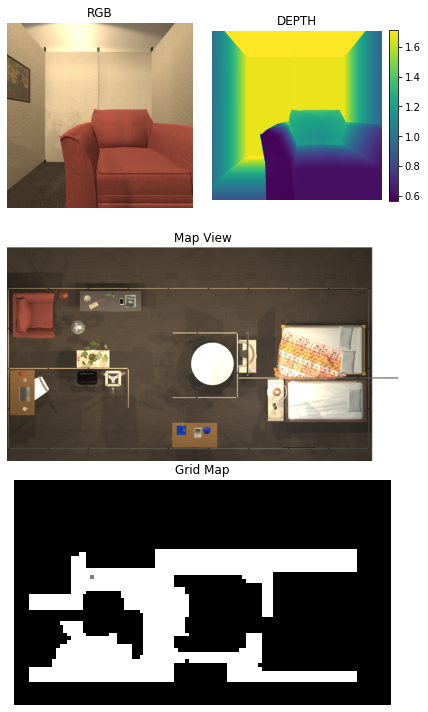

In [6]:
controller.step(
    action="Teleport",
    position = rstate[100],
    rotation = dict(x=0,y=270,z=0)
)

scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1)

pos = controller.last_event.metadata['agent']['position']
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [7]:
proj = attn2map(controller,sm.gridmap)
fbe = gridmap(controller,scene_bounds,clip_gradcam,proj,sm)
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)

0.6868000030517578 10.52444076538086 -5.351839542388916 0.5981607437133789


In [8]:
controller.step(
    action="Teleport",
    position = rstate[100],
    rotation = dict(x=0,y=270,z=0)
        )

pos = controller.last_event.metadata['agent']['position']
try:
    min_path = get_shortest_path_to_object(controller,query_object['objectId'],pos)
    min_length = 0
    last_pos = pos
    for p in min_path:
        min_length += math.sqrt((last_pos['x']-p['x'])**2+(last_pos['z']-p['z'])**2)
        last_pos = p
except:
    min_length = 0.1

In [9]:
query_object_name = query_object['objectType']

new_query_object_name = ''
if len(query_object_name)>2:
    for i, letter in enumerate(query_object_name):
        if i and letter.isupper():
            new_query_object_name += ' '
        new_query_object_name += letter.lower()
else:
    new_query_object_name = query_object_name
clip_gradcam.set_text(new_query_object_name)
print(new_query_object_name)

laptop


/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.0, 'y': 0.91, 'z': -2.4000000000000004}]
start planning


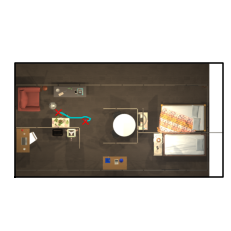

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


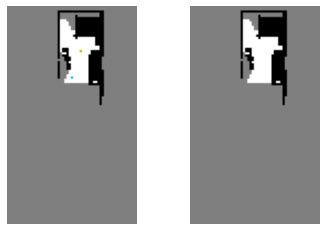

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}, {'x': 5.300000000000001, 'y': 0.91, 'z': -1.6000000000000005}]
start planning


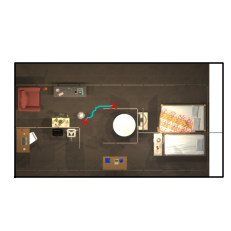

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


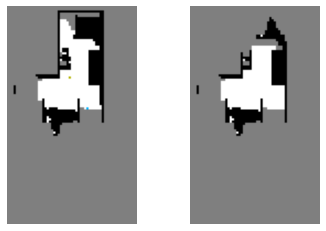

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}, {'x': 6.7, 'y': 0.91, 'z': -1.7000000000000006}]
start planning


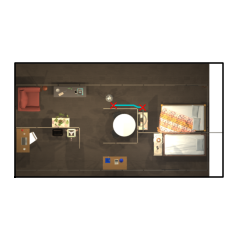

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


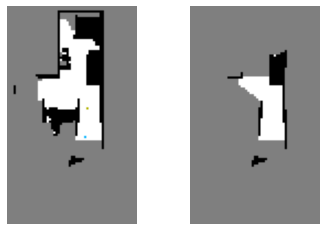

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}, {'x': 7.2, 'y': 0.91, 'z': -2.7000000000000006}, {'x': 8.0, 'y': 0.91, 'z': -1.5000000000000004}]
start planning


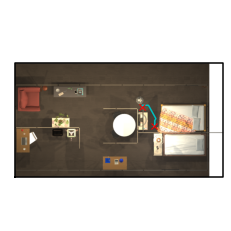

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


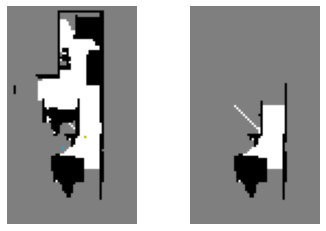

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}, {'x': 8.0, 'y': 0.91, 'z': -1.5000000000000004}]
start planning


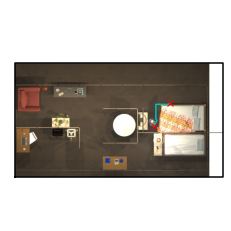

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


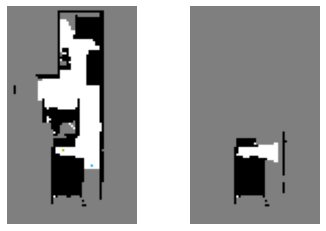

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}, {'x': 9.299999999999999, 'y': 0.91, 'z': -1.6000000000000005}]
start planning


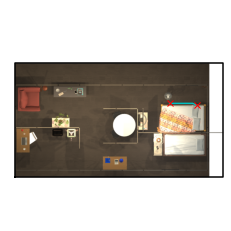

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


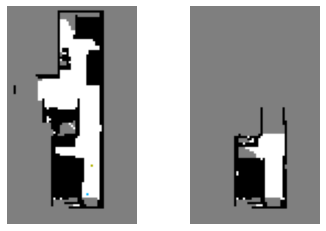

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 4.5, 'y': 0.91, 'z': -4.000000000000001}]
start planning


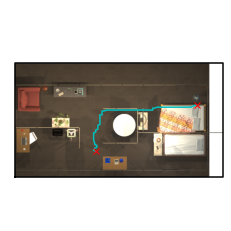

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


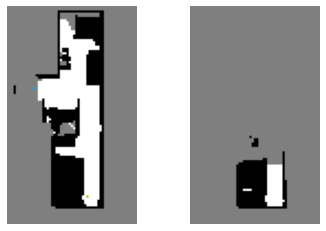

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 3.1000000000000005, 'y': 0.91, 'z': -4.300000000000001}]
start planning


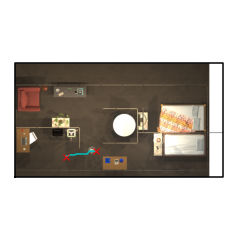

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


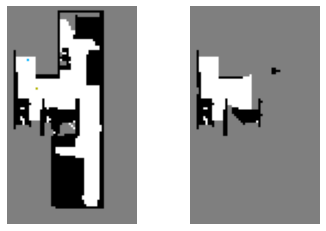

[{'x': 1.4000000000000001, 'y': 0.91, 'z': -2.6000000000000005}, {'x': 1.6, 'y': 0.91, 'z': -4.6000000000000005}]
start planning


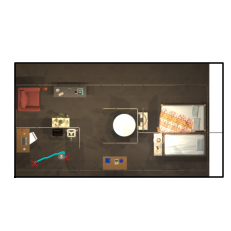

/home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

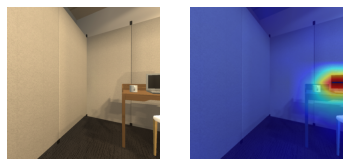

0.21067480743619582


In [10]:
sucess = False
total_path_len = 0
while sucess != True:
    cpos = controller.last_event.metadata['agent']['position']
    gt_find,find,path_len, reset_map  = step_frontier(fbe,rrtplanner,controller,query_object,clip_gradcam=clip_gradcam,vis=True,verbose=True)
    sucess = gt_find*find
    total_path_len += path_len
    npos = controller.last_event.metadata['agent']['position']
    if math.sqrt((cpos['x']-npos['x'])**2+(cpos['z']-npos['z'])**2) < 0.1:
        reset_map = True
    if reset_map:
        proj.reset()
        fbe.reset()
    if total_path_len>50:
        break
SPL = sucess*min_length/total_path_len
print(SPL)

In [11]:
total_path_len

19.34559388414275

In [12]:
controller.stop()